In [46]:
import requests
import json
import torch
import glob
import os
import numpy as np
import shutil
import argparse
import logging
import pandas as pd
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import warnings
import time
from tqdm import tqdm
from collections import Counter

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 65
CLS_DICT = {'0': 'Bird',
 '1': 'Ground-Animal',
 '2': 'Curb',
 '3': 'Fence',
 '4': 'Guard-Rail',
 '5': 'Barrier',
 '6': 'Wall',
 '7': 'Bike-Lane',
 '8': 'Crosswalk---Plain',
 '9': 'Curb-Cut',
 '10': 'Parking',
 '11': 'Pedestrian-Area',
 '12': 'Rail-Track',
 '13': 'Road',
 '14': 'Service-Lane',
 '15': 'Sidewalk',
 '16': 'Bridge',
 '17': 'Building',
 '18': 'Tunnel',
 '19': 'Person',
 '20': 'Bicyclist',
 '21': 'Motorcyclist',
 '22': 'Other-Rider',
 '23': 'Lane-Marking---Crosswalk',
 '24': 'Lane-Marking---General',
 '25': 'Mountain',
 '26': 'Sand',
 '27': 'Sky',
 '28': 'Snow',
 '29': 'Terrain',
 '30': 'Vegetation',
 '31': 'Water',
 '32': 'Banner',
 '33': 'Bench',
 '34': 'Bike-Rack',
 '35': 'Billboard',
 '36': 'Catch-Basin',
 '37': 'CCTV-Camera',
 '38': 'Fire-Hydrant',
 '39': 'Junction-Box',
 '40': 'Mailbox',
 '41': 'Manhole',
 '42': 'Phone-Booth',
 '43': 'Pothole',
 '44': 'Street-Light',
 '45': 'Pole',
 '46': 'Traffic-Sign-Frame',
 '47': 'Utility-Pole',
 '48': 'Traffic-Light',
 '49': 'Traffic-Sign-(Back)',
 '50': 'Traffic-Sign-(Front)',
 '51': 'Trash-Can',
 '52': 'Bicycle',
 '53': 'Boat',
 '54': 'Bus',
 '55': 'Car',
 '56': 'Caravan',
 '57': 'Motorcycle',
 '58': 'On-Rails',
 '59': 'Other-Vehicle',
 '60': 'Trailer',
 '61': 'Truck',
 '62': 'Wheeled-Slow',
 '63': 'Car-Mount',
 '64': 'Ego-Vehicle'}

# Get helper function
def addIndice(output_max):
    set_of_pixels = torch.unique(output_max, return_counts=True)
    set_dictionary = {}
    for i in range(NUM_CLASSES):
            set_dictionary[str(i)] = 0
    for pixel,count in zip(set_of_pixels[0], set_of_pixels[1]):
        set_dictionary[str(pixel.item())] = count.item()
    set_dictionary['Total'] = int(np.sum(list(set_dictionary.values())))
    return set_dictionary

def addInstance(output_max):
    list_unique, list_counts = torch.unique(out[0]['segmentation'].int(), return_counts=True)

    if -1 in list_unique:
        list_unique = list_unique[1:]
        list_counts = list_counts[1:]

    total = torch.sum(list_counts).item()

    matching_dict = {}
    for i, k in zip(range(len(out[0]['segments_info'])), out[0]['segments_info']):
        matching_dict[i] = int(k['label_id'])

    set_dictionary = {}
    for i in range(NUM_CLASSES):
                set_dictionary[str(i)] = 0

    for i, k in zip(list_unique, list_counts):
        set_dictionary[str(matching_dict[i.item()])] += k.item()
        
    set_dictionary['Total'] = total

    return set_dictionary

def addInstanceCounts(output_max):

    instance_dictionary = {}
    
    instance_dictionary = {}
    for i in range(NUM_CLASSES):
                instance_dictionary[str(i)] = 0
    
    # for each segment, draw its legend
    for segment in out[0]['segments_info']:
        segment_id = segment['id']
        segment_label_id = str(segment['label_id'])
        instance_dictionary[segment_label_id] += 1

    return instance_dictionary

# Load Mask2Former
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-panoptic")
model = model.to(device)

In [87]:
out[0]['segments_info']

[{'id': 0, 'label_id': 27, 'was_fused': False, 'score': 0.966301},
 {'id': 1, 'label_id': 30, 'was_fused': False, 'score': 0.915689},
 {'id': 2, 'label_id': 13, 'was_fused': False, 'score': 0.9474},
 {'id': 3, 'label_id': 17, 'was_fused': False, 'score': 0.904236},
 {'id': 4, 'label_id': 64, 'was_fused': False, 'score': 0.920119},
 {'id': 5, 'label_id': 3, 'was_fused': False, 'score': 0.692318},
 {'id': 6, 'label_id': 29, 'was_fused': False, 'score': 0.574526},
 {'id': 7, 'label_id': 55, 'was_fused': False, 'score': 0.640219},
 {'id': 8, 'label_id': 2, 'was_fused': False, 'score': 0.475104},
 {'id': 9, 'label_id': 45, 'was_fused': False, 'score': 0.454926},
 {'id': 10, 'label_id': 45, 'was_fused': False, 'score': 0.277171}]

In [42]:
print(device)

cpu


In [90]:
# Set start state
image_indicators_dict = {}
image_instances_dict = {}

# Create output folder if none exist
if not os.path.exists(f'./outputs'):
    os.makedirs(f'./outputs')

# Get list of images
image_set = [i for i in os.listdir(os.path.join(os.getcwd(),'test')) if '.jpg' in i]

In [91]:
for i in image_set[0:]:
    print(i)

139784358078458.jpg
113256921118965.jpg
130326246141798.jpg
130816899585186.jpg
133260865451337.jpg
130593129639737.jpg
128261845943214.jpg
113165904586142.jpg


In [92]:
for i, image in enumerate(tqdm(image_set[0:])):
    print(f'Segmenting {image}')
    img = Image.open(os.path.join(os.getcwd(),'test/', f'{image}'))
    inputs = processor(images=img, return_tensors="pt")
    with torch.no_grad():
        pixel_values = inputs['pixel_values'].to(device)
        pixel_mask = inputs['pixel_mask'].to(device)
        outputs = model(pixel_values = pixel_values, pixel_mask = pixel_mask)
    out = processor.post_process_instance_segmentation(outputs, target_sizes=[img.size[::-1]], threshold=0.25)
    image_indicators_dict[image] = addInstance(out)
    image_instances_dict[image] = addInstanceCounts(out)

  0%|                                                                   | 0/8 [00:00<?, ?it/s]

Segmenting 139784358078458.jpg


 12%|███████▍                                                   | 1/8 [00:01<00:10,  1.49s/it]

Segmenting 113256921118965.jpg


 25%|██████████████▊                                            | 2/8 [00:02<00:08,  1.38s/it]

Segmenting 130326246141798.jpg


 38%|██████████████████████▏                                    | 3/8 [00:04<00:06,  1.31s/it]

Segmenting 130816899585186.jpg


 50%|█████████████████████████████▌                             | 4/8 [00:05<00:05,  1.30s/it]

Segmenting 133260865451337.jpg


 62%|████████████████████████████████████▉                      | 5/8 [00:06<00:03,  1.27s/it]

Segmenting 130593129639737.jpg


 75%|████████████████████████████████████████████▎              | 6/8 [00:07<00:02,  1.26s/it]

Segmenting 128261845943214.jpg


 88%|███████████████████████████████████████████████████▋       | 7/8 [00:09<00:01,  1.28s/it]

Segmenting 113165904586142.jpg


100%|███████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.29s/it]


In [94]:
df = pd.DataFrame.from_dict(image_instances_dict, orient='index')

In [98]:
image_instances_dict['139784358078458.jpg']

{'0': 0,
 '1': 0,
 '2': 1,
 '3': 1,
 '4': 1,
 '5': 1,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0,
 '10': 0,
 '11': 0,
 '12': 0,
 '13': 1,
 '14': 1,
 '15': 0,
 '16': 0,
 '17': 0,
 '18': 0,
 '19': 0,
 '20': 0,
 '21': 0,
 '22': 0,
 '23': 0,
 '24': 1,
 '25': 0,
 '26': 0,
 '27': 1,
 '28': 0,
 '29': 1,
 '30': 1,
 '31': 0,
 '32': 0,
 '33': 0,
 '34': 0,
 '35': 0,
 '36': 0,
 '37': 0,
 '38': 0,
 '39': 0,
 '40': 0,
 '41': 0,
 '42': 0,
 '43': 0,
 '44': 1,
 '45': 9,
 '46': 0,
 '47': 0,
 '48': 0,
 '49': 0,
 '50': 0,
 '51': 0,
 '52': 0,
 '53': 0,
 '54': 1,
 '55': 9,
 '56': 0,
 '57': 0,
 '58': 0,
 '59': 0,
 '60': 0,
 '61': 2,
 '62': 0,
 '63': 0,
 '64': 0}

In [76]:
img = Image.open(os.path.join(os.getcwd(),'test/', '139784358078458.jpg'))

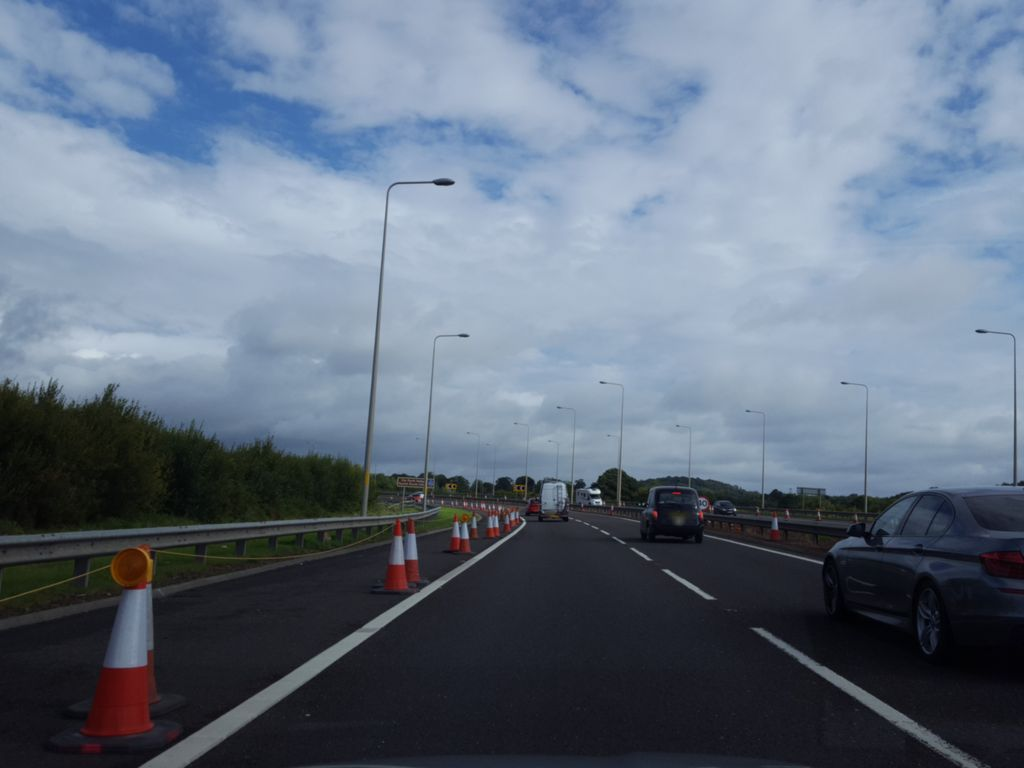

In [77]:
img

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

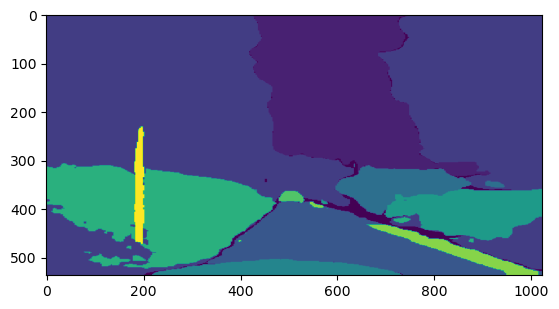

In [71]:
plt.imshow(out[0]['segmentation'])

### Merge CSV

In [ ]:
from glob import glob
import pandas as pd

In [ ]:
paths[0]

In [ ]:
out2 = pd.read_csv(paths[1])

In [ ]:
total = pd.DataFrame()

In [ ]:
total = pd.concat([total, out2], axis=0)

In [ ]:
def merge_csv(filepath):

    extension = filepath + '*.csv'
    paths = glob(extension)
    
    combined = pd.DataFrame()
    for path in paths:
        temp = pd.read_csv(path)
        combined = pd.concat([combined, temp], axis=0)
    
    return combined

In [ ]:
all_df = merge_csv('./outputs/')

In [ ]:
len(all_df)

In [ ]:
all_df.to_csv('./final/ssd1_1676060.csv')

In [ ]:
# Closing log file

with open('yourlog.log', 'w'):
    pass
